In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [18]:
## Load and resize data
labels = ['covid', 'normal']
img_size = 450
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                #img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)   ## convert RGB to grayscale
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [19]:
## Load train and test dataset
train = get_data('TrainData')
val = get_data('TestData')

E:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

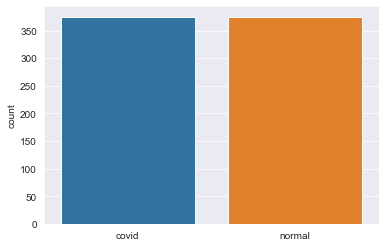

In [20]:
## Visualize the data
l = []                 # label list
for i in train:
    if(i[1] == 0):
        l.append("covid")
    else:
        l.append("normal")
sns.set_style('darkgrid')
sns.countplot(l)

E:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

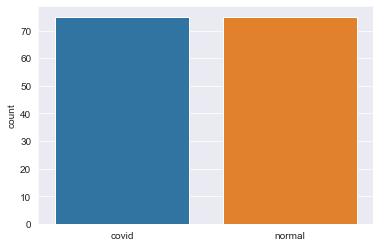

In [21]:
## Visualize the data
l = []                 # label list
for i in val:
    if(i[1] == 0):
        l.append("covid")
    else:
        l.append("normal")
sns.set_style('darkgrid')
sns.countplot(l)

In [22]:
## Data preprocessing
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [23]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

datagen.fit(x_train)

In [24]:
# Data augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [45]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(450,450,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(AveragePooling2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(AveragePooling2D())


model.add(Flatten())
model.add(Dense(64,activation="sigmoid"))
model.add(Dropout(0.7))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 450, 450, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 450, 450, 32)      128       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 225, 225, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 225, 225, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 225, 225, 32)      128       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 401408)           

In [46]:
from keras import backend as K
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [47]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy', sensitivity, specificity])

In [48]:
history = model.fit(x_train,y_train,epochs = 5 , validation_data = (x_val, y_val))

Epoch 1/5
24/24 [==============================] - 158s 7s/step - loss: 0.0976 - accuracy: 0.9640 - sensitivity: 0.9468 - specificity: 0.9904 - val_loss: 0.7646 - val_accuracy: 0.7733 - val_sensitivity: 0.3262 - val_specificity: 0.6000
Epoch 2/5
24/24 [==============================] - 149s 6s/step - loss: 0.0405 - accuracy: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.5478 - val_accuracy: 0.8200 - val_sensitivity: 0.3854 - val_specificity: 0.6000
Epoch 3/5
24/24 [==============================] - 150s 6s/step - loss: 0.0353 - accuracy: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.3617 - val_accuracy: 0.8200 - val_sensitivity: 0.3854 - val_specificity: 0.6000
Epoch 4/5
24/24 [==============================] - 147s 6s/step - loss: 0.0358 - accuracy: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.8400 - val_sensitivity: 0.4140 - val_specificity: 0.6000
Epoch 5/5
24/24 [==============================] - 139s 

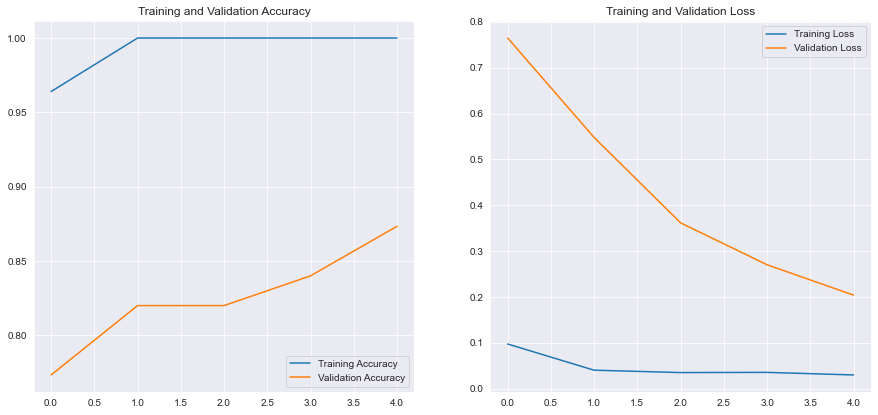

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['covid (Class 0)','normal (Class 1)']))

                  precision    recall  f1-score   support

 covid (Class 0)       0.80      1.00      0.89        75
normal (Class 1)       1.00      0.75      0.85        75

        accuracy                           0.87       150
       macro avg       0.90      0.87      0.87       150
    weighted avg       0.90      0.87      0.87       150

